In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax
import jax.numpy as jnp
from jax import random

import sys
sys.path.append('wl-mechanics')
sys.path.append('..')
import datasets
from models import utils as mutils
from models import mlp
import train_utils as tutils
from flax.training import checkpoints

In [3]:
from configs import toy_ubot as config
config = config.get_config()
key = random.PRNGKey(config.seed)
key, init_key = random.split(key)
X, _, _, inv_scaler, _ = datasets.get_data(config, init_key)

2024-03-22 20:30:02.880777: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


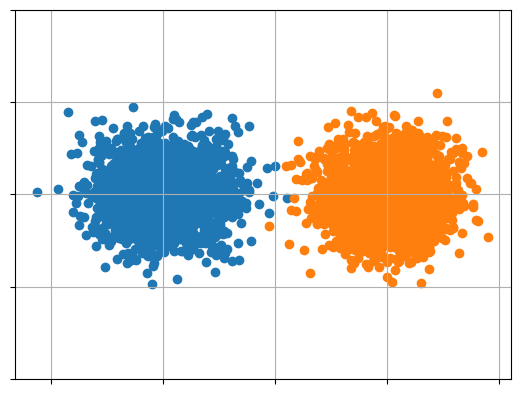

In [4]:
plt.scatter(X[0][:,0], X[0][:,1])
plt.scatter(X[1][:,0], X[1][:,1])
plt.xticks(range(-2,3), [])
plt.yticks(range(-2,3), [])
plt.grid()

In [17]:
# chkpt_id = 11021717 # ot
# chkpt_id = 11031078 # sb
# chkpt_id = 11031137 # phot
# chkpt_id = 11031225 # ubot

In [29]:
checkpoint_dir = f'wl-mechanics/checkpoint/{chkpt_id}/checkpoints'

key, *init_key = random.split(key, 3)
model_s, initial_params = mutils.init_model_s(init_key[0], config.model_s)
optimizer_s = tutils.get_optimizer(config.optimizer_s)
opt_state_s = optimizer_s.init(initial_params)
time_sampler, init_sampler_state = tutils.get_time_sampler(config)

state_s = mutils.State(step=1, opt_state=opt_state_s,
                      model_params=initial_params,
                      ema_rate=config.model_s.ema_rate,
                      params_ema=initial_params,
                      sampler_state=init_sampler_state,
                      key=key, wandbid=np.random.randint(int(1e7),int(1e8)))
state_s = checkpoints.restore_checkpoint(checkpoint_dir, state_s, prefix='chkpt_s_')

In [19]:
@jax.jit
def grad_vf(t,y,state):
  s = mutils.get_model_fn(model_s, 
                          state.params_ema if config.eval.use_ema else state.model_params, 
                          train=False)
  dsdx = jax.grad(lambda _t, _x: s(_t*jnp.ones((_x.shape[0],1)), _x).sum(), argnums=1)
  return dsdx(t,y)

@jax.jit
def grad_vf_weighted(t,y,state):
      y, w = y
      s = mutils.get_model_fn(model_s, 
                              state.params_ema if config.eval.use_ema else state.model_params, 
                              train=False)
      dsdx = jax.grad(lambda _t, _x: s(_t, _x).sum(), argnums=1)
      return (dsdx(t*jnp.ones((y.shape[0],1)),y), s(t*jnp.ones((y.shape[0],1)), y))

In [20]:
dt = 1e-2
n = int(1/dt)
solution = np.zeros((X[0].shape[0],n+1,2))
solution[:,0,:] = X[0]
t = np.zeros((n+1,1))
key, loop_key = random.split(key)
for i in range(n):
  solution[:,i+1,:] = solution[:,i,:] + dt*grad_vf(t[i], solution[:,i,:], state_s)
  t[i+1] = t[i] + dt

In [13]:
dt = 1e-2
n = int(1/dt)
N = 200
solution = np.zeros((N,n+1,2))
solution[:,0,:] = X[0][:N]
logw = np.zeros((N,n+1,1))
t = np.zeros((n+1,1))
key, loop_key = random.split(key)
for i in range(100):
  eps = random.normal(random.fold_in(loop_key, i), shape=(N, 2))
  dxdt, dlogwdt = grad_vf_weighted(t[i], (solution[:,i,:], logw[:,i,:]), state_s)
  solution[:,i+1,:] = solution[:,i,:] + dt*dxdt
  logw[:,i+1,:] = logw[:,i,:] + dt*dlogwdt
  t[i+1] = t[i] + dt
w = jnp.exp(logw[:,:,0] - jax.scipy.special.logsumexp(logw[:,:,0], axis=0, keepdims=True))

In [70]:
dt = 1e-2
n = int(1/dt)
solution = np.zeros((X[0].shape[0],n+1,2))
solution[:,0,:] = X[0]
t = np.zeros((n+1,1))
key, loop_key = random.split(key)
for i in range(n):
  eps = random.normal(random.fold_in(loop_key, i), shape=(X[0].shape[0], 2))
  solution[:,i+1,:] = solution[:,i,:] + dt*grad_vf(t[i], solution[:,i,:], state_s) + jnp.sqrt(dt)*config.sigma*eps
  t[i+1] = t[i] + dt

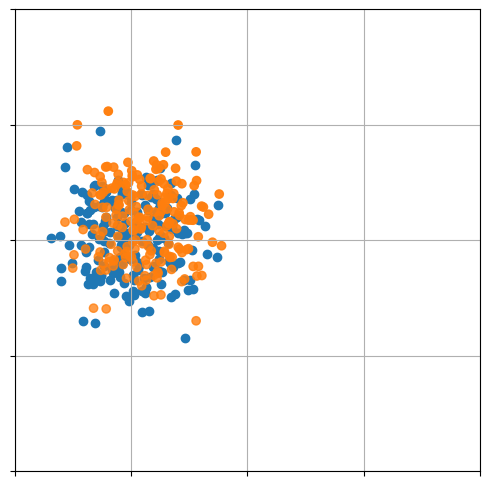

In [16]:
from matplotlib.collections import LineCollection

n = N
w_normed = w/w.max()
figsize(6,6)
plt.scatter(solution[:n,0,0], solution[:n,0,1], alpha=1.0)
plt.scatter(solution[:n,-1,0], solution[:n,-1,1], alpha=w_normed[:,-1])
# for i in range(n):
#   points = solution[i,::4,:].reshape(-1,1,2)
#   segments = np.concatenate([points[:-1], points[1:]], axis=1)
#   lc = LineCollection(segments, cmap=plt.get_cmap('Blues'), norm=plt.Normalize(0, 0.6), alpha=0.3)
#   lc.set_array(w_normed[i,::4])
#   plt.gca().add_collection(lc)
plt.xticks(range(-2,3), [])
plt.yticks(range(-2,3), [])
plt.grid()
# plt.savefig('wl-mechanics/assets/ubot.pdf', bbox_inches='tight')

In [57]:
w_normed.shape

(200, 101)

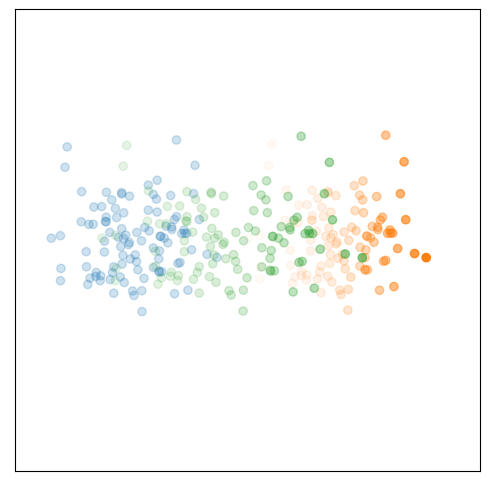

In [55]:
n = 100
w_normed = w/w.max()
figsize(6,6)
plt.scatter(solution[:n,0,0], solution[:n,0,1], alpha=w_normed[:,0])
plt.scatter(solution[:n,-1,0], solution[:n,-1,1], alpha=w_normed[:,-1])
plt.scatter(solution[:n,50,0], solution[:n,50,1], alpha=w_normed[:,50])
plt.xticks([], [])
plt.yticks([], [])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()

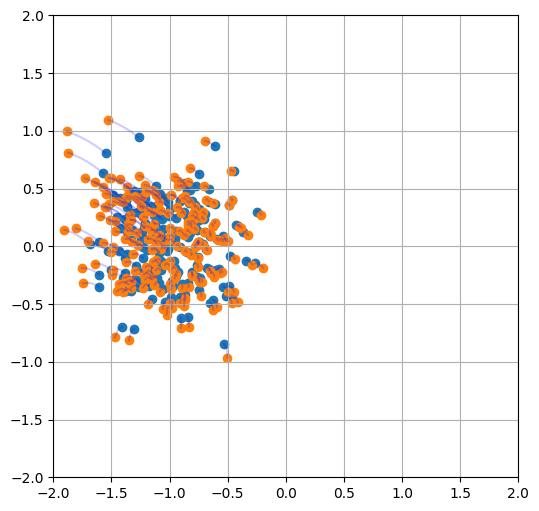

In [21]:
n = 200
figsize(6,6)
plt.scatter(solution[:n,0,0], solution[:n,0,1])
plt.scatter(solution[:n,-1,0], solution[:n,-1,1])
for i in range(n):
  plt.plot(solution[i,:,0], solution[i,:,1], c='blue', alpha=0.2)
# plt.xticks(range(-2,3), [])
# plt.yticks(range(-2,3), [])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
# plt.savefig('wl-mechanics/assets/phot.pdf', bbox_inches='tight')

In [63]:
solution.shape

(2000, 101, 2)

In [56]:
!mkdir wl-mechanics/assets/gifs/ubot

In [63]:
def generate_frames(solution, dir, n=200):
  for frame_id in range(solution.shape[1]):
    figsize(6,6)
    plt.scatter(solution[:n,0,0], solution[:n,0,1])
    plt.scatter(solution[:n,-1,0], solution[:n,-1,1])
    for i in range(n):
      plt.plot(solution[i,:frame_id,0], solution[i,:frame_id,1], c='blue', alpha=0.2)
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xticks([], [])
    plt.yticks([], [])
    # plt.grid()
    plt.box(False)
    plt.savefig(f'{dir}/frame_{frame_id:04}.png', bbox_inches='tight')
    plt.clf()
    
def generate_frames(solution, dir):
  for frame_id in range(solution.shape[1]):
    figsize(6,6)
    plt.scatter(solution[:,frame_id,0], solution[:,frame_id,1], alpha=w_normed[:,frame_id])
    plt.scatter(solution[:,-1,0], solution[:,-1,1], alpha=w_normed[:,-1])
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xticks([], [])
    plt.yticks([], [])
    # plt.grid()
    plt.box(False)
    plt.savefig(f'{dir}/frame_{frame_id:04}.png', bbox_inches='tight')
    plt.clf()

In [64]:
generate_frames(solution, 'wl-mechanics/assets/gifs/ubot')

<Figure size 600x600 with 0 Axes>

In [65]:
!convert -delay 5 -loop 0 -dispose previous wl-mechanics/assets/gifs/ubot/*.png wl-mechanics/assets/gifs/ubot.gif

In [66]:
from IPython.display import Image

In [67]:
Image(open('wl-mechanics/assets/gifs/ubot.gif','rb').read())